In [60]:
import torch
import numpy as np
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.models import efficientnet_b0
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import Adam

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [61]:
BASE_DIR = Path.cwd()
BASE_DIR


PosixPath('/home/tasfreak/Desktop/ML/CIFAR Project')

In [62]:
os.chdir(BASE_DIR)


In [63]:
from Training import ModelTrainer, show_missclassification

In [64]:
path = BASE_DIR/'Dataset/cifar-10/'

data_df = pd.read_csv(path/'trainLabels.csv',delimiter= ',')
data_df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [65]:
if 'id' in data_df.columns:
    data_df['path']=str(path)+'/train/'+data_df['id'].astype(str)+'.png'
    data_df.drop(columns='id',inplace=True)
data_df['path'][0]

'/home/tasfreak/Desktop/ML/CIFAR Project/Dataset/cifar-10/train/1.png'

In [66]:
sample_df = data_df.sample(frac=1,random_state=42).reset_index(drop=True) # shuffle the dataframe
sample_df

,label,path
0,horse,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
1,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
2,airplane,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
3,frog,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
4,automobile,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
...,...,...
49995,horse,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49996,bird,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49997,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...
49998,ship,/home/tasfreak/Desktop/ML/CIFAR Project/Datase...


In [67]:
data_df.label.value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [68]:
train_df = sample_df.sample(frac = 0.9).reset_index(drop=True)
val_df = sample_df.drop(train_df.index).reset_index(drop=True)
val_df.label.value_counts()

label
horse         534
deer          524
airplane      510
frog          505
dog           503
bird          502
ship          499
automobile    487
cat           474
truck         462
Name: count, dtype: int64

In [86]:
mean=[0.4911, 0.4821, 0.4465]
std=[0.2470, 0.2434, 0.2616]

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]
)

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(size=32,padding=4),
        transforms.RandomRotation(degrees=15),
        # transforms.RandomApply(
        #     [transforms.ColorJitter(0.1, 0.1, 0.1, 0.02)],
        #     p=0.5
        # ),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]
)


In [70]:

le = LabelEncoder()
le.fit(sample_df['label'])

LabelEncoder()

In [71]:
class CifarDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        super().__init__()
        self.img_path = list(dataframe['path'])
        if type(dataframe['label'][0])==np.int64:
            self.labels = dataframe['label']
        else:
            self.labels = torch.tensor(le.transform(dataframe['label'])).to(device)
        self.transform = transform

    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        path = self.img_path[index]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img).to(device)
        return img, self.labels[index]
        


In [72]:
train_dataset = CifarDataset(train_df,train_transform)
val_dataset = CifarDataset(val_df, transform)


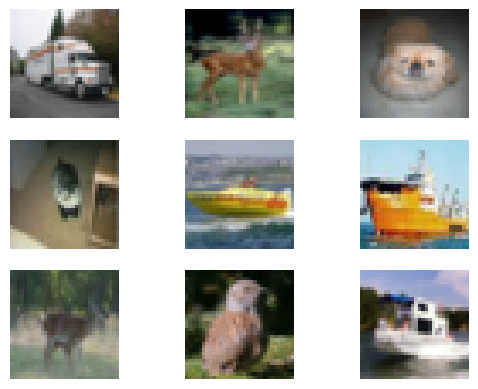

In [73]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['path'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [74]:
# model = resnet18()
model = efficientnet_b0(weights='DEFAULT')
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [75]:
model.classifier=nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(model.classifier[1].in_features, 10)
    )
model.to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [76]:
BATCH_SIZE = 128
EPOCHS = 150
LR = 1e-3
N_Models = 1

In [77]:
train_data = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle = True)
val_data = DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [78]:
loss_project = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = LR,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

In [79]:
model_trainer = ModelTrainer(model, train_data=train_data,val_data=val_data,loss_function=loss_project, optimizer=optimizer, scheduler=scheduler)
model_trainer.train(EPOCHS,n_models=N_Models,save='Experiments/moreAugmentationwithEfficientNet.txt')

Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully saved the string to Experiments/moreAugmentationwithEfficientNet.txt
Successfully sav

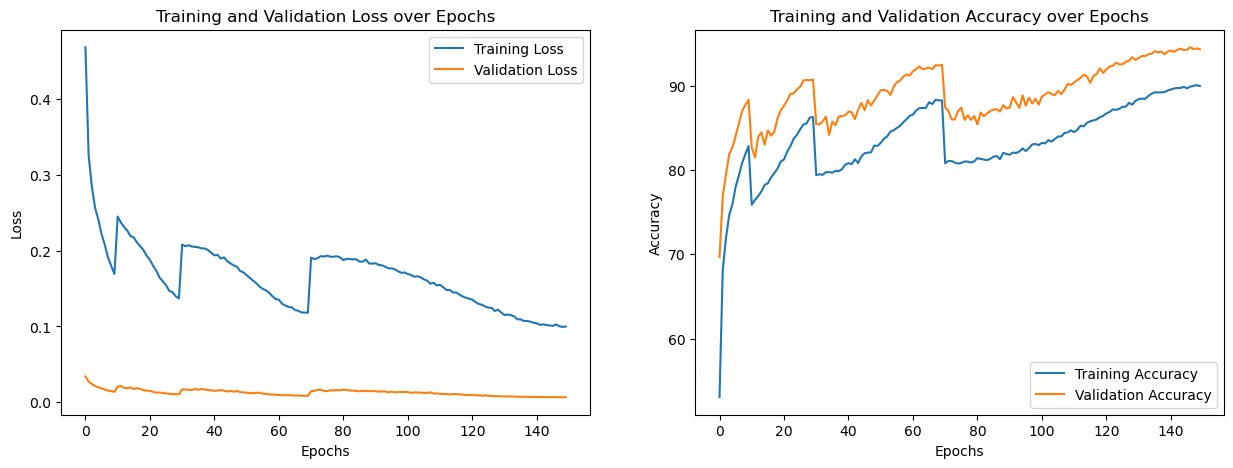

In [80]:
model_trainer.plot_metrics('Experiments/moreAugmentationwithEfficientNet.png')

In [81]:
torch.save(model.state_dict(), "efficientnetmodelwithmoreAugmentation.pth")

In [82]:
# Create a test dataset, run the trained model on it, and write predictions to CSV.
test_dir = BASE_DIR/'Dataset/cifar-10/test'
path_len = len(str(test_dir))+1
test_files = sorted([test_dir/f for f in os.listdir(test_dir)], key = lambda x: int(str(x)[path_len:-4]))

test_df = pd.DataFrame(test_files, columns=['path'])
test_df['label'] = [int(str(x)[path_len:-4]) for x in test_files]  # dummy labels for compatibility

test_dataset = CifarDataset(test_df, transform)  # use the previously defined `transform`
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

pred_ids = []
pred_labels = []

test_model = efficientnet_b0(weights='DEFAULT')
test_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(test_model.classifier[1].in_features, 10)
)
test_model=test_model.to(device)
test_model.load_state_dict(torch.load("efficientnetmodelwithmoreAugmentation.pth", map_location=device))


<All keys matched successfully>

In [ ]:
test_model.eval()

with torch.no_grad():
    for imgs, id in test_loader:
        ensemble_outputs = torch.zeros((imgs.size(0), N_Models , 10))
        for i in range(N_Models):
            outputs = test_model(imgs)
            ensemble_outputs[:, i, :] = outputs
        avg_outputs = ensemble_outputs.mean(dim=1).to(device)
        preds = avg_outputs.argmax(dim=1).cpu().numpy()
        labels = le.inverse_transform(preds)
        pred_ids.extend(id.tolist())
        pred_labels.extend(labels.tolist())

submission_df = pd.DataFrame({"id": pred_ids, "label": pred_labels})
out_csv = "efficientnetwithmoreAugmentation.csv"
submission_df.to_csv(out_csv, index=False)
print(f"Saved predictions to {out_csv}")

Saved predictions to efficientnetwithmoreAugmentation.csv


In [84]:
val_model = efficientnet_b0(weights='DEFAULT')
val_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(val_model.classifier[1].in_features, 10)
)
val_model=val_model.to(device)
val_model.load_state_dict(torch.load("efficientnetmodelwithmoreAugmentation.pth", map_location=device))
val_model.eval()



EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6906811..2.1277733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3362255..1.4411288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6262347..1.9968168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8294913..1.9659187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8517973..2.1277733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6918137..1.9174327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.586878

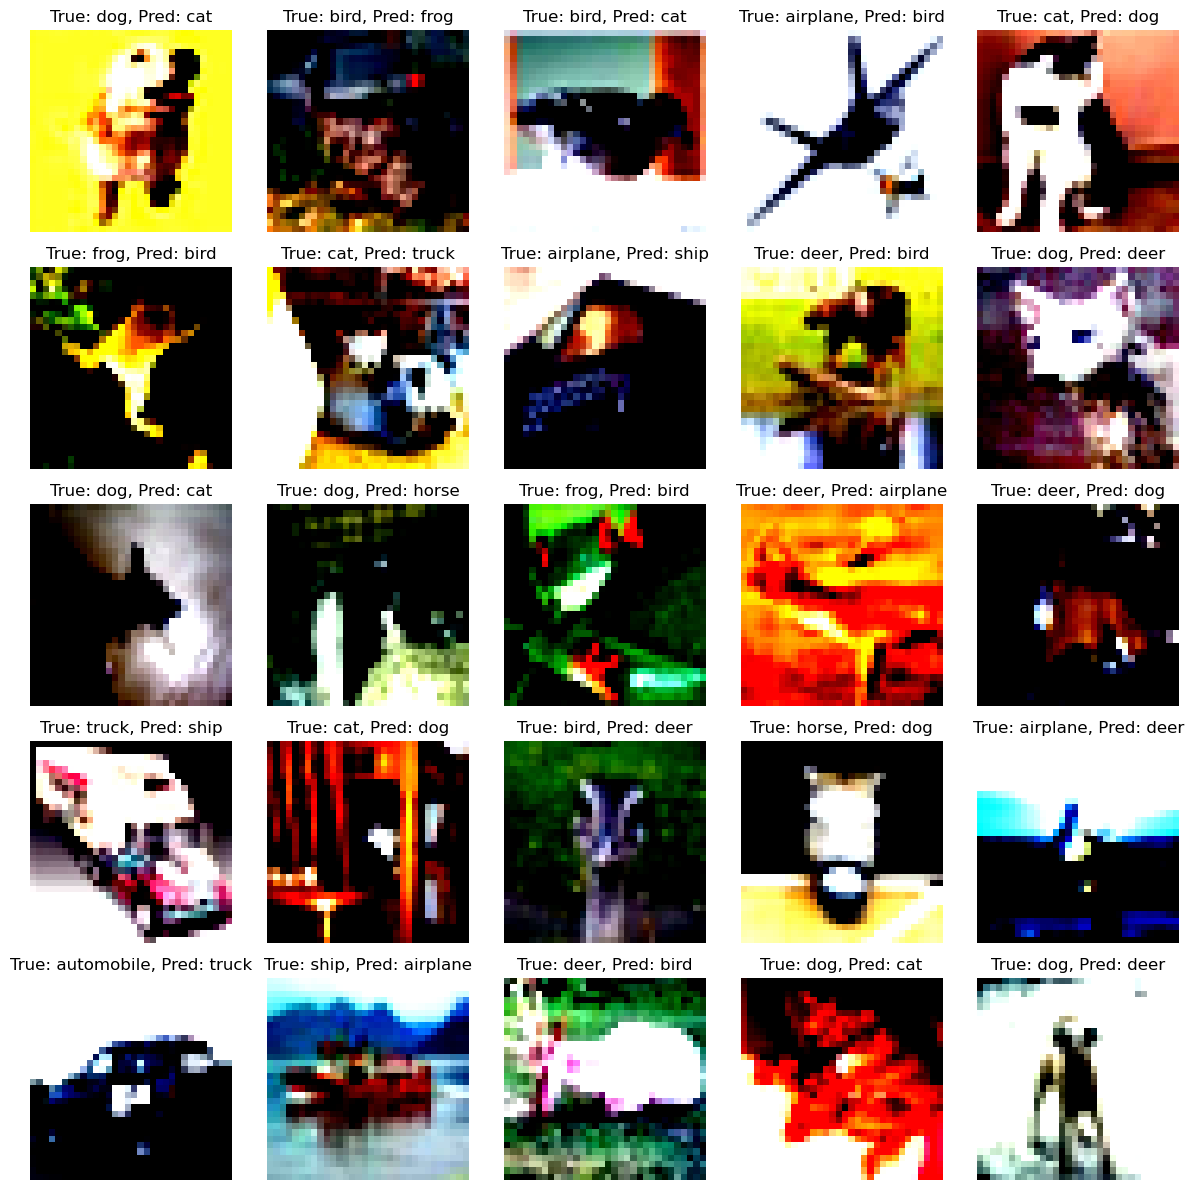

In [85]:
show_missclassification(val_model, val_data,le)